# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [1]:
!pip install torchinfo

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from collections import Counter

from torchinfo import summary
import utils
import wandb
from IPython.display import Image

In [28]:
import sys

DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [4]:
BATCH_SIZE = 256  # tamaño del batch

# Cargamos datos + Análisis Exploratorio


In [5]:
TRAIN_DATA_PATH = "mitbih_train.csv"
TEST_DATA_PATH = "mitbih_test.csv"

In [14]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

df_train = df_train.dropna()
df_test = df_test.dropna()

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

In [15]:
print(f"El dataset cuenta con {df.iloc[:,-1].nunique()} clases distintas")

El dataset cuenta con 5 clases distintas


In [16]:
TARGET_NAMES = [
    "Normal",
    "Arritmia supraventricular",
    "Arritmia ventricular",
    "Latido fusionado",
    "Latido desconocido",
]


## Distribución del dataset por clases

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: title={'center': 'Número de muestras por clase'}, xlabel='187'>

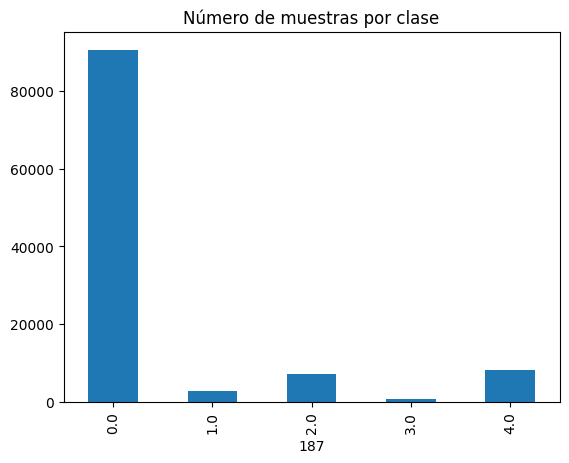

In [17]:
class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar", title="Número de muestras por clase")

Se observa claramente un set de datos muy desbalanceado con una gran mayoría de muestras etiquetadas con 0, por lo que se toma la decision de calcular los pesos de las clases para luego asignarlos a la hora de calcular la pérdida.

El tensor de pesos de clases se le pasa cómo parámetro al criterion.

In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df.iloc[:, -1]),
    y=df.iloc[:, -1]
)

# Convert to a dictionary for easier use
class_weights_dict = dict(zip(np.unique(df.iloc[:, -1]), class_weights))
print("Class weights:")
print(class_weights_dict)

# Convert to tensor for use with PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("\nClass weights tensor:")
print(class_weights_tensor)

Class weights:
{0.0: 0.2416319862234929, 1.0: 7.876646275638719, 2.0: 3.0250414593698176, 3.0: 27.259277708592776, 4.0: 2.722875979599453}

Class weights tensor:
tensor([ 0.2416,  7.8766,  3.0250, 27.2593,  2.7229], device='cuda:0')


## Creamos la clase MITBIHDataSet

In [19]:
class MITBIHDataSet(Dataset):
    def __init__(self, df_features, df_target, num_classes):
        self.x_df = df_features.values
        self.y_df = df_target.values
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

In [20]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [21]:
SEED = 23

In [22]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

## Graficamos la distribución de las clases en train y validación

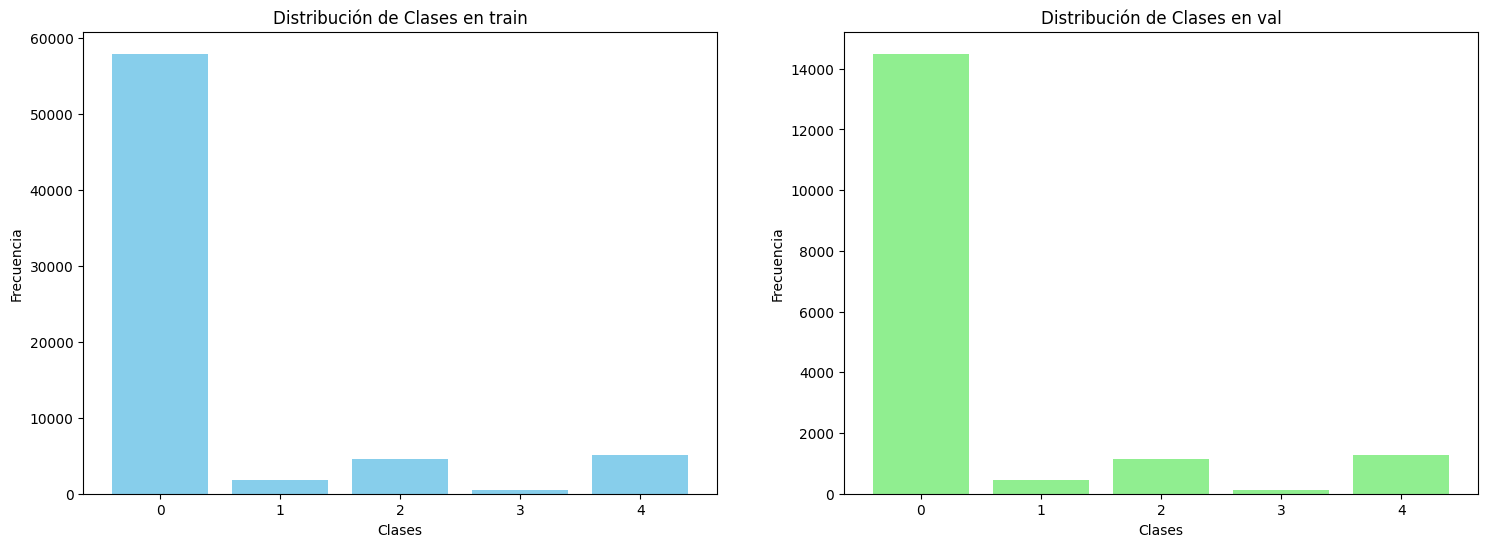

In [23]:
# Contar la frecuencia de cada clase en cada conjunto
class_counts_train = y_train.value_counts()
class_counts_val = y_val.value_counts()

# Crear subplots para los histogramas
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma para train
axes[0].bar(class_counts_train.index, class_counts_train.values, color="skyblue")
axes[0].set_title("Distribución de Clases en train")
axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Frecuencia")

# Histograma para val
axes[1].bar(class_counts_val.index, class_counts_val.values, color="lightgreen")
axes[1].set_title("Distribución de Clases en val")
axes[1].set_xlabel("Clases")
axes[1].set_ylabel("Frecuencia")

plt.show()

Observamos que en ambos datasets la distribución es la misma

## Graficamos las señales promedio para cada una de las 5 clases del set

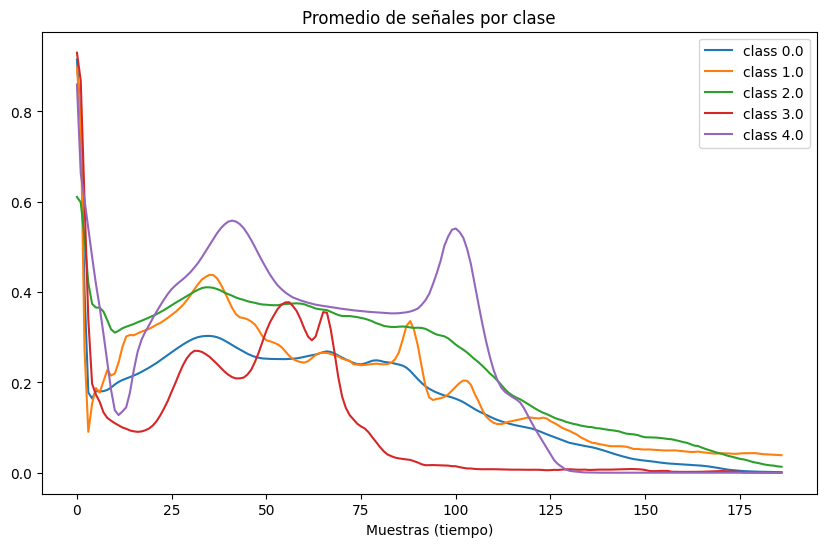

In [24]:
plt.figure(figsize=(10,6))
classes_to_plot = [0.0,1.0,2.0,3.0,4.0]

# Combine X_train and y_train for easier grouping
train_combined = X_train.copy()
train_combined['target'] = y_train

for c in classes_to_plot:
    # Select samples for the current class and calculate the mean
    average_sample = train_combined[train_combined['target'] == c].iloc[:, :-1].mean(axis=0)
    plt.plot(average_sample, label=f'class {c}')

plt.legend()
plt.title('Promedio de señales por clase')
plt.xlabel('Muestras (tiempo)')
plt.show()

In [25]:
nclasses = df.iloc[:,-1].nunique()

train_dataset = MITBIHDataSet(X_train, y_train, nclasses)
val_dataset = MITBIHDataSet(X_val, y_val, nclasses)
test_dataset = MITBIHDataSet(X_test, y_test, nclasses)

In [32]:
def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [33]:
train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE
)

## Creamos un modelo RNN simple

Instanciamos un modelo RNN con una capa de dropout entre la RNN y la capa lineal. Lo entrenamos durante 50 épocas con Early Stopping y una paciencia de 10 epocas.

In [29]:
class ECG_RNN(nn.Module):
    def __init__(self,input_size=1, hidden_size=64, num_classes=5,num_layers=2,dropout=0.3):
        super(ECG_RNN,self).__init__()
        self.rnn = nn.RNN(input_size=input_size,num_layers=num_layers, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, _ = self.rnn(x) # Capas, B, HIDDEN_DIM
        last = out[:, -1, :]
        return self.fc(last)

model_rnn = ECG_RNN().to(DEVICE)



In [30]:
optimizer_1 = optim.Adam(model_rnn.parameters(), lr=0.001)
criterion_1 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [34]:
train_errors_rnn, val_errors_rnn = utils.train(model_rnn,optimizer_1,criterion_1,train_loader,val_loader,DEVICE,epochs=50,patience = 10)

Epoch: 001 | Train Loss: 1.59721 | Val Loss: 1.58463
Epoch: 002 | Train Loss: 1.58434 | Val Loss: 1.58154
Epoch: 003 | Train Loss: 1.57698 | Val Loss: 1.57038
Epoch: 004 | Train Loss: 1.58257 | Val Loss: 1.58062
Epoch: 005 | Train Loss: 1.57844 | Val Loss: 1.57947
Epoch: 006 | Train Loss: 1.57836 | Val Loss: 1.58303
Epoch: 007 | Train Loss: 1.61228 | Val Loss: 1.58329
Epoch: 008 | Train Loss: 1.58157 | Val Loss: 1.57959
Epoch: 009 | Train Loss: 1.58034 | Val Loss: 1.58161
Epoch: 010 | Train Loss: 1.58014 | Val Loss: 1.58021
Epoch: 011 | Train Loss: 1.57849 | Val Loss: 1.57617
Epoch: 012 | Train Loss: 1.58140 | Val Loss: 1.58005
Epoch: 013 | Train Loss: 1.58017 | Val Loss: 1.58289
Detener entrenamiento en la época 12, la mejor pérdida fue 1.57038


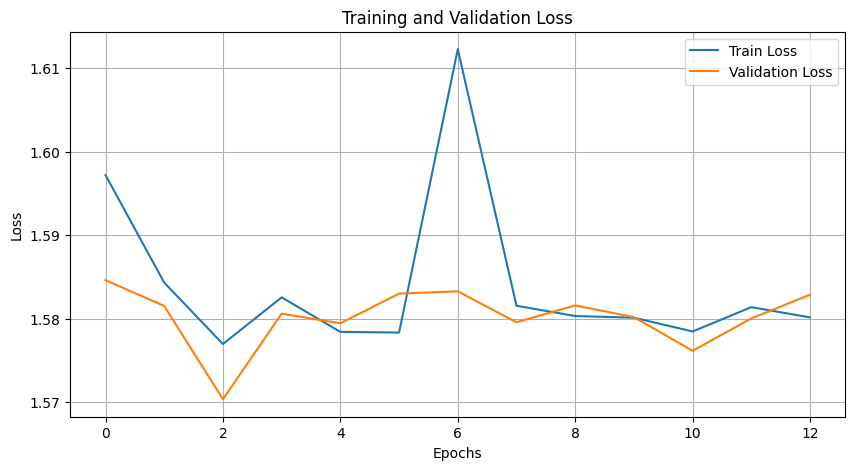

Accuracy: 0.0849

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.01      0.02     18118
           1       0.21      0.11      0.14       556
           2       0.22      0.02      0.03      1448
           3       0.00      0.00      0.00       162
           4       0.08      1.00      0.14      1608

    accuracy                           0.08     21892
   macro avg       0.26      0.23      0.07     21892
weighted avg       0.69      0.08      0.03     21892



In [35]:
utils.plot_taining(train_errors_rnn, val_errors_rnn)
utils.model_calassification_report(model_rnn, test_loader, DEVICE, nclasses)

## Probamos LSTM

Creamos un modelo LSTM, al igual que con el modelo anterior, utilizamos una capa de dropout entre la lstm y la capa lineal que determina la clase.

In [49]:
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, (h, c) = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model_lstm = ECG_LSTM().to(DEVICE)

In [50]:
optimizer_2 = optim.Adam(model_lstm.parameters(), lr=0.001)
criterion_2 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [51]:
train_errors_lstm, val_errors_lstm = utils.train(model_lstm,optimizer_2,criterion_2,train_loader,val_loader,DEVICE,epochs=100,patience = 10)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 001 | Train Loss: 1.59082 | Val Loss: 1.58127
Epoch: 002 | Train Loss: 1.56015 | Val Loss: 1.53217
Epoch: 003 | Train Loss: 1.47784 | Val Loss: 1.27752
Epoch: 004 | Train Loss: 1.24103 | Val Loss: 1.17949
Epoch: 005 | Train Loss: 1.18382 | Val Loss: 1.15564
Epoch: 006 | Train Loss: 1.15675 | Val Loss: 1.12524
Epoch: 007 | Train Loss: 1.12428 | Val Loss: 1.18087
Epoch: 008 | Train Loss: 1.09319 | Val Loss: 1.09835
Epoch: 009 | Train Loss: 1.09208 | Val Loss: 1.10924
Epoch: 010 | Train Loss: 1.06054 | Val Loss: 1.03765
Epoch: 011 | Train Loss: 1.10538 | Val Loss: 1.10516
Epoch: 012 | Train Loss: 1.09999 | Val Loss: 1.06539
Epoch: 013 | Train Loss: 1.07915 | Val Loss: 1.06281
Epoch: 014 | Train Loss: 1.07118 | Val Loss: 1.04686
Epoch: 015 | Train Loss: 1.04511 | Val Loss: 0.98123
Epoch: 016 | Train Loss: 1.06598 | Val Loss: 1.04259
Epoch: 017 | Train Loss: 1.05209 | Val Loss: 0.99026
Epoch: 018 | Train Loss: 1.02217 | Val Loss: 1.02799
Epoch: 019 | Train Loss: 1.00082 | Val Loss: 0

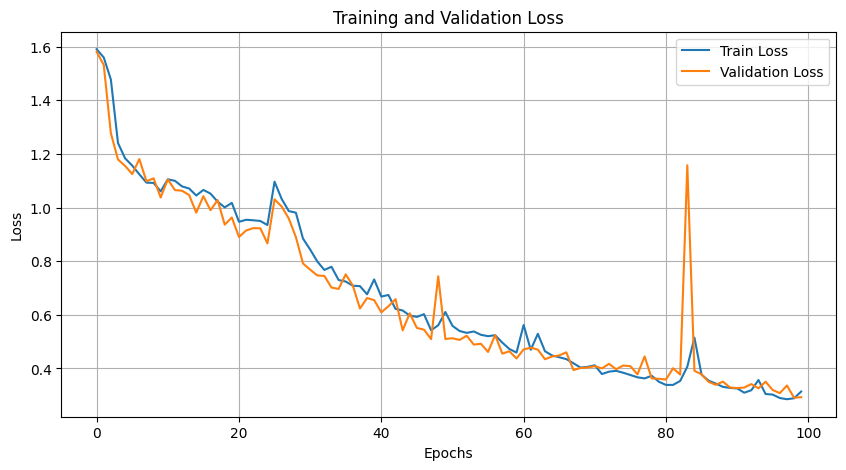

Accuracy: 0.8950

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     18118
           1       0.33      0.75      0.45       556
           2       0.82      0.91      0.86      1448
           3       0.15      0.92      0.26       162
           4       0.93      0.96      0.94      1608

    accuracy                           0.90     21892
   macro avg       0.64      0.89      0.69     21892
weighted avg       0.95      0.90      0.92     21892



In [52]:
utils.plot_taining(train_errors_lstm, val_errors_lstm)
utils.model_calassification_report(model_lstm, test_loader, DEVICE, nclasses)

Se observa que los resultados mejoraron mucho respecto a los obtenidos con la RNN, y además no llego a overfittear durante las 100 épocas, por lo que probablemente podriamos haber obtenido mejores resultados de haberlo entrenado alguna época mas. En el experimento en W&B probaremos con una mayor cantidad de épocas y una mayor paciencia.

## Por último probamos con GRU

Al igual que para los modelos anteriores utilizamos la capa de dropout intermedia

In [53]:
class ECG_GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, h = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)


model_gru = ECG_GRU().to(DEVICE)


In [54]:
optimizer_3 = optim.Adam(model_gru.parameters(), lr=0.001)
criterion_3 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [55]:
train_errors_gru, val_errors_gru = utils.train(model_gru,optimizer_3,criterion_3,train_loader,val_loader,DEVICE,epochs=100,patience = 10)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 001 | Train Loss: 1.58640 | Val Loss: 1.55794
Epoch: 002 | Train Loss: 1.38301 | Val Loss: 1.21259
Epoch: 003 | Train Loss: 1.24670 | Val Loss: 1.23669
Epoch: 004 | Train Loss: 1.21805 | Val Loss: 1.20517
Epoch: 005 | Train Loss: 1.17796 | Val Loss: 1.18779
Epoch: 006 | Train Loss: 1.15777 | Val Loss: 1.13243
Epoch: 007 | Train Loss: 1.13595 | Val Loss: 1.07309
Epoch: 008 | Train Loss: 1.09177 | Val Loss: 1.03298
Epoch: 009 | Train Loss: 1.00960 | Val Loss: 1.00588
Epoch: 010 | Train Loss: 0.94491 | Val Loss: 0.91815
Epoch: 011 | Train Loss: 0.90939 | Val Loss: 0.85308
Epoch: 012 | Train Loss: 0.87691 | Val Loss: 0.81964
Epoch: 013 | Train Loss: 0.83574 | Val Loss: 0.79623
Epoch: 014 | Train Loss: 0.80668 | Val Loss: 0.78515
Epoch: 015 | Train Loss: 0.74824 | Val Loss: 0.67412
Epoch: 016 | Train Loss: 0.68371 | Val Loss: 0.64793
Epoch: 017 | Train Loss: 0.66006 | Val Loss: 0.57271
Epoch: 018 | Train Loss: 0.59744 | Val Loss: 0.55018
Epoch: 019 | Train Loss: 0.57734 | Val Loss: 0

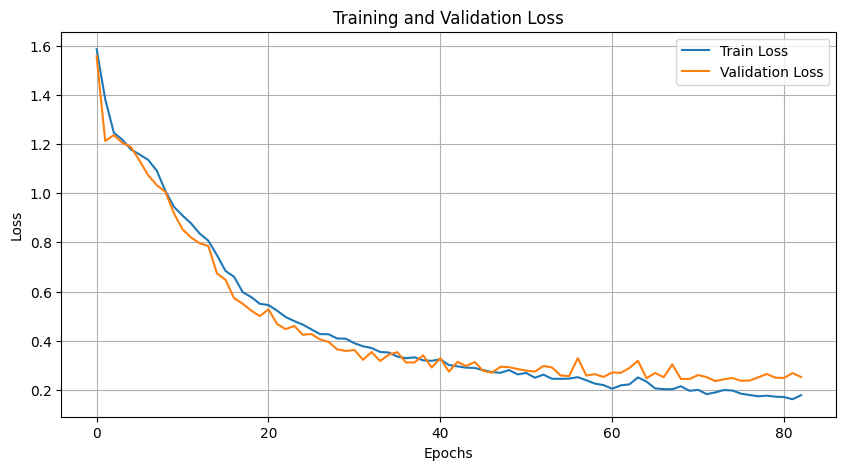

Accuracy: 0.8732

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     18118
           1       0.25      0.85      0.39       556
           2       0.80      0.95      0.87      1448
           3       0.16      0.92      0.27       162
           4       0.92      0.98      0.95      1608

    accuracy                           0.87     21892
   macro avg       0.62      0.91      0.68     21892
weighted avg       0.95      0.87      0.90     21892



In [56]:
utils.plot_taining(train_errors_gru, val_errors_gru)
utils.model_calassification_report(model_gru, test_loader, DEVICE, nclasses)

En este caso si termino de entrenar previo a las 100 épocas gracias al Early Stopping, alcanzando mejores valores de perdida en validación que la LSTM.

Profundizaremos en la selección de hiperparámetros para la GRU en los experimentos en Weights & Biases

In [57]:
WANDB_TEAM_NAME = "joacoguerrae-ort"
WANDB_PROJECT = "[wandb-labo2-guerra-sanes]"
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: joacoguerrae (joacoguerrae-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [37]:
class ECG_GRU_WANDB(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=5,
                 dropout=0.3, bidirectional=False):
        super(ECG_GRU_WANDB,self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        feat_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feat_dim, num_classes)
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        out, _ = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)

In [80]:
sweep_config = {
  "method": "bayes",
  "metric": {"name": "val_loss", "goal": "minimize"},
  "parameters": {
    "lr": {"min": 1e-4, "max": 3e-3, "distribution": "log_uniform_values"},
    "hidden_size": {"values": [48, 64, 96, 128]},
    "num_layers": {"values": [1, 2, 3]},
    "dropout": {"values": [0.1, 0.2, 0.3, 0.4]},
    "bidirectional": {"values": [False, True]},
    "weight_decay": {"values": [0.0, 1e-4, 5e-4, 1e-3]},
    "batch_size": {"values": [64, 128, 256]},
    "clip_grad_norm": {"values": [0.0, 0.5, 1.0]},
    "epochs": {"value": 200},
    "optimizer_name": {"values": ["adam", "sgd"]},
    "momentum": {"values": [0.0, 0.9, 0.95]},
  },
  "early_terminate": {"type": "hyperband", "min_iter": 6},

}

In [81]:
def train_with_wandb(config=None):
    with wandb.init(config=config):
        cfg = wandb.config

        # Crear dataloaders con el batch_size del sweep
        train_loader_sweep, val_loader_sweep, test_loader_sweep = get_data_loaders(
            batch_size=cfg.batch_size
        )

        # Creamos el Modelo
        model = ECG_GRU_WANDB(
            input_size=1,
            hidden_size=cfg.hidden_size,
            num_layers=cfg.num_layers,
            num_classes=5,
            dropout=cfg.dropout,
            bidirectional=cfg.bidirectional
        ).to(DEVICE)

        # Definir el optimizador según la configuración
        if cfg.optimizer_name == "adam":
            optimizer = optim.Adam(
                model.parameters(),
                lr=cfg.lr,
                weight_decay=cfg.weight_decay
            )
        elif cfg.optimizer_name == "sgd":
            optimizer = optim.SGD(
                model.parameters(),
                lr=cfg.lr,
                momentum=cfg.momentum, # Now momentum is available in cfg
                weight_decay=cfg.weight_decay
            )

        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


        train_errors, val_errors = utils.train(model,
            optimizer=optimizer,
            criterion=criterion,
            do_early_stopping=True,
            train_loader=train_loader_sweep,
            val_loader=val_loader_sweep,
            device=DEVICE,
            epochs=100,
            patience=15)

        if val_errors:
            best_val = float(min(val_errors))
            wandb.run.summary["val_loss"] = best_val

        # Evaluamos el conjunto en test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader_sweep:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_accuracy = 100. * correct / total
        test_loss = test_loss / len(test_loader_sweep)

        # Log de métricas finales
        wandb.log({
            "test_accuracy": test_accuracy,
            "test_loss": test_loss
        })

        print(f"Test Accuracy: {test_accuracy:.2f}%")



In [82]:
#Creamos el sweep
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

print(f"Sweep ID: {sweep_id}")

Create sweep with ID: rfrlg07v
Sweep URL: https://wandb.ai/joacoguerrae-ort/%5Bwandb-labo2-guerra-sanes%5D/sweeps/rfrlg07v
Sweep ID: rfrlg07v


In [ ]:
wandb.agent(sweep_id, function=train_with_wandb, count=30)

wandb: Agent Starting Run: dcorlp2m with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 0
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.001148715403851141
wandb: 	momentum: 0
wandb: 	num_layers: 2
wandb: 	optimizer_name: sgd
wandb: 	weight_decay: 0.001


Epoch: 001 | Train Loss: 1.60612 | Val Loss: 1.60292
Epoch: 002 | Train Loss: 1.60238 | Val Loss: 1.60007
Epoch: 003 | Train Loss: 1.60082 | Val Loss: 1.59906
Epoch: 004 | Train Loss: 1.59970 | Val Loss: 1.59862
Epoch: 005 | Train Loss: 1.60043 | Val Loss: 1.59849
Epoch: 006 | Train Loss: 1.60010 | Val Loss: 1.59841
Epoch: 007 | Train Loss: 1.59949 | Val Loss: 1.59830
Epoch: 008 | Train Loss: 1.60036 | Val Loss: 1.59829
Epoch: 009 | Train Loss: 1.59996 | Val Loss: 1.59828
Epoch: 010 | Train Loss: 1.59951 | Val Loss: 1.59821
Epoch: 011 | Train Loss: 1.59936 | Val Loss: 1.59818
Epoch: 012 | Train Loss: 1.60005 | Val Loss: 1.59816
Epoch: 013 | Train Loss: 1.60000 | Val Loss: 1.59815
Epoch: 014 | Train Loss: 1.60021 | Val Loss: 1.59816
Epoch: 015 | Train Loss: 1.59996 | Val Loss: 1.59808
Epoch: 016 | Train Loss: 1.59991 | Val Loss: 1.59807
Epoch: 017 | Train Loss: 1.60004 | Val Loss: 1.59806
Epoch: 018 | Train Loss: 1.60021 | Val Loss: 1.59803
Epoch: 019 | Train Loss: 1.60108 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,82.6512
test_loss,1.50168
val_loss,1.59457


wandb: Agent Starting Run: 9x5wzepa with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 0.5
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.0001062916578142448
wandb: 	momentum: 0.9
wandb: 	num_layers: 2
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.001


Epoch: 001 | Train Loss: 1.60104 | Val Loss: 1.59722
Epoch: 002 | Train Loss: 1.57184 | Val Loss: 1.51621
Epoch: 003 | Train Loss: 1.37143 | Val Loss: 1.29708
Epoch: 004 | Train Loss: 1.27839 | Val Loss: 1.24589
Epoch: 005 | Train Loss: 1.25539 | Val Loss: 1.24486
Epoch: 006 | Train Loss: 1.24765 | Val Loss: 1.26276
Epoch: 007 | Train Loss: 1.23798 | Val Loss: 1.24220
Epoch: 008 | Train Loss: 1.23220 | Val Loss: 1.22316
Epoch: 009 | Train Loss: 1.22776 | Val Loss: 1.21895
Epoch: 010 | Train Loss: 1.22184 | Val Loss: 1.23786
Epoch: 011 | Train Loss: 1.21908 | Val Loss: 1.19867
Epoch: 012 | Train Loss: 1.20176 | Val Loss: 1.19325
Epoch: 013 | Train Loss: 1.19089 | Val Loss: 1.17037
Epoch: 014 | Train Loss: 1.18618 | Val Loss: 1.24703
Epoch: 015 | Train Loss: 1.18020 | Val Loss: 1.17019
Epoch: 016 | Train Loss: 1.17132 | Val Loss: 1.14460
Epoch: 017 | Train Loss: 1.16534 | Val Loss: 1.13689
Epoch: 018 | Train Loss: 1.15820 | Val Loss: 1.13112
Epoch: 019 | Train Loss: 1.14751 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,57.2812
test_loss,1.11384
val_loss,1.02294


wandb: Agent Starting Run: 79no4qk1 with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 0
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 128
wandb: 	lr: 0.0002951806057606584
wandb: 	momentum: 0.9
wandb: 	num_layers: 1
wandb: 	optimizer_name: sgd
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.61307 | Val Loss: 1.61170
Epoch: 002 | Train Loss: 1.61096 | Val Loss: 1.61027
Epoch: 003 | Train Loss: 1.60993 | Val Loss: 1.60948
Epoch: 004 | Train Loss: 1.60919 | Val Loss: 1.60906
Epoch: 005 | Train Loss: 1.60923 | Val Loss: 1.60880
Epoch: 006 | Train Loss: 1.60908 | Val Loss: 1.60866
Epoch: 007 | Train Loss: 1.60927 | Val Loss: 1.60856
Epoch: 008 | Train Loss: 1.60879 | Val Loss: 1.60850
Epoch: 009 | Train Loss: 1.60907 | Val Loss: 1.60845
Epoch: 010 | Train Loss: 1.60872 | Val Loss: 1.60842
Epoch: 011 | Train Loss: 1.60867 | Val Loss: 1.60839
Epoch: 012 | Train Loss: 1.60905 | Val Loss: 1.60837
Epoch: 013 | Train Loss: 1.60891 | Val Loss: 1.60833
Epoch: 014 | Train Loss: 1.60922 | Val Loss: 1.60833
Epoch: 015 | Train Loss: 1.60891 | Val Loss: 1.60833
Epoch: 016 | Train Loss: 1.60885 | Val Loss: 1.60831
Epoch: 017 | Train Loss: 1.60883 | Val Loss: 1.60826
Epoch: 018 | Train Loss: 1.60887 | Val Loss: 1.60825
Epoch: 019 | Train Loss: 1.60904 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,82.62379
test_loss,1.58105
val_loss,1.6062


wandb: Agent Starting Run: rpsywm4e with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 0.5
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.0019476702606700568
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.53405 | Val Loss: 1.24286
Epoch: 002 | Train Loss: 0.91194 | Val Loss: 0.59216
Epoch: 003 | Train Loss: 0.52498 | Val Loss: 0.41100
Epoch: 004 | Train Loss: 0.41912 | Val Loss: 0.35469
Epoch: 005 | Train Loss: 0.36787 | Val Loss: 0.34278
Epoch: 006 | Train Loss: 0.34687 | Val Loss: 0.31197
Epoch: 007 | Train Loss: 0.29821 | Val Loss: 0.32519
Epoch: 008 | Train Loss: 0.29909 | Val Loss: 0.29949
Epoch: 009 | Train Loss: 0.27299 | Val Loss: 0.28487
Epoch: 010 | Train Loss: 0.26717 | Val Loss: 0.29055
Epoch: 011 | Train Loss: 0.24773 | Val Loss: 0.24585
Epoch: 012 | Train Loss: 0.23805 | Val Loss: 0.28763
Epoch: 013 | Train Loss: 0.24162 | Val Loss: 0.25425
Epoch: 014 | Train Loss: 0.21087 | Val Loss: 0.25890
Epoch: 015 | Train Loss: 0.22083 | Val Loss: 0.26627
Epoch: 016 | Train Loss: 0.20722 | Val Loss: 0.26889
Epoch: 017 | Train Loss: 0.21972 | Val Loss: 0.22052
Epoch: 018 | Train Loss: 0.20159 | Val Loss: 0.25654
Epoch: 019 | Train Loss: 0.17855 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,93.66435
test_loss,0.18612
val_loss,0.20237


wandb: Agent Starting Run: 63qi1vnc with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 0.5
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.0008231227534914328
wandb: 	momentum: 0.9
wandb: 	num_layers: 1
wandb: 	optimizer_name: sgd
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.60839 | Val Loss: 1.60622
Epoch: 002 | Train Loss: 1.60721 | Val Loss: 1.60588
Epoch: 003 | Train Loss: 1.60714 | Val Loss: 1.60553
Epoch: 004 | Train Loss: 1.60695 | Val Loss: 1.60540
Epoch: 005 | Train Loss: 1.60566 | Val Loss: 1.60525
Epoch: 006 | Train Loss: 1.60555 | Val Loss: 1.60510
Epoch: 007 | Train Loss: 1.60615 | Val Loss: 1.60498
Epoch: 008 | Train Loss: 1.60616 | Val Loss: 1.60479
Epoch: 009 | Train Loss: 1.60625 | Val Loss: 1.60466
Epoch: 010 | Train Loss: 1.60567 | Val Loss: 1.60474
Epoch: 011 | Train Loss: 1.60569 | Val Loss: 1.60447
Epoch: 012 | Train Loss: 1.60531 | Val Loss: 1.60430
Epoch: 013 | Train Loss: 1.60573 | Val Loss: 1.60406
Epoch: 014 | Train Loss: 1.60462 | Val Loss: 1.60388
Epoch: 015 | Train Loss: 1.60459 | Val Loss: 1.60361
Epoch: 016 | Train Loss: 1.60456 | Val Loss: 1.60344
Epoch: 017 | Train Loss: 1.60361 | Val Loss: 1.60324
Epoch: 018 | Train Loss: 1.60398 | Val Loss: 1.60304
Epoch: 019 | Train Loss: 1.60350 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,32.99836
test_loss,1.40296
val_loss,1.25787


wandb: Agent Starting Run: roogfkyt with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 0.5
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.002813187426682547
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.59925 | Val Loss: 1.58100
Epoch: 002 | Train Loss: 0.86140 | Val Loss: 0.52411
Epoch: 003 | Train Loss: 0.48651 | Val Loss: 0.37840
Epoch: 004 | Train Loss: 0.39417 | Val Loss: 0.40047
Epoch: 005 | Train Loss: 0.34650 | Val Loss: 0.34640
Epoch: 006 | Train Loss: 0.32215 | Val Loss: 0.31475
Epoch: 007 | Train Loss: 0.29369 | Val Loss: 0.27035
Epoch: 008 | Train Loss: 0.28011 | Val Loss: 0.25668
Epoch: 009 | Train Loss: 0.27592 | Val Loss: 0.28432
Epoch: 010 | Train Loss: 0.25923 | Val Loss: 0.28847
Epoch: 011 | Train Loss: 0.23864 | Val Loss: 0.23885
Epoch: 012 | Train Loss: 0.23859 | Val Loss: 0.23578
Epoch: 013 | Train Loss: 0.21644 | Val Loss: 0.24669
Epoch: 014 | Train Loss: 0.22806 | Val Loss: 0.25322
Epoch: 015 | Train Loss: 0.21895 | Val Loss: 0.22292
Epoch: 016 | Train Loss: 0.19957 | Val Loss: 0.28027
Epoch: 017 | Train Loss: 0.21552 | Val Loss: 0.20768
Epoch: 018 | Train Loss: 0.20791 | Val Loss: 0.28847
Epoch: 019 | Train Loss: 0.20700 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,91.93769
test_loss,0.22638
val_loss,0.1714


wandb: Agent Starting Run: ku3eml0p with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.0020908441325107703
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: sgd
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.60930 | Val Loss: 1.60617
Epoch: 002 | Train Loss: 1.60749 | Val Loss: 1.60561
Epoch: 003 | Train Loss: 1.60735 | Val Loss: 1.60658
Epoch: 004 | Train Loss: 1.60688 | Val Loss: 1.60557
Epoch: 005 | Train Loss: 1.60667 | Val Loss: 1.60415
Epoch: 006 | Train Loss: 1.60301 | Val Loss: 1.60462
Epoch: 007 | Train Loss: 1.60160 | Val Loss: 1.59724
Epoch: 008 | Train Loss: 1.59413 | Val Loss: 1.58937
Epoch: 009 | Train Loss: 1.58920 | Val Loss: 1.59998
Epoch: 010 | Train Loss: 1.58133 | Val Loss: 1.57790
Epoch: 011 | Train Loss: 1.58164 | Val Loss: 1.57869
Epoch: 012 | Train Loss: 1.58219 | Val Loss: 1.58263
Epoch: 013 | Train Loss: 1.58019 | Val Loss: 1.57583
Epoch: 014 | Train Loss: 1.58160 | Val Loss: 1.59090
Epoch: 015 | Train Loss: 1.58175 | Val Loss: 1.58870
Epoch: 016 | Train Loss: 1.58097 | Val Loss: 1.57591
Epoch: 017 | Train Loss: 1.58111 | Val Loss: 1.57485
Epoch: 018 | Train Loss: 1.57853 | Val Loss: 1.58561
Epoch: 019 | Train Loss: 1.57655 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,91.24794
test_loss,0.29623
val_loss,0.29257


wandb: Agent Starting Run: nbm3odve with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.001397256734022684
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.57433 | Val Loss: 1.58535
Epoch: 002 | Train Loss: 1.30140 | Val Loss: 1.17966
Epoch: 003 | Train Loss: 1.15778 | Val Loss: 1.16083
Epoch: 004 | Train Loss: 0.99248 | Val Loss: 0.85861
Epoch: 005 | Train Loss: 0.77382 | Val Loss: 0.60408
Epoch: 006 | Train Loss: 0.63718 | Val Loss: 0.61426
Epoch: 007 | Train Loss: 0.55935 | Val Loss: 0.48267
Epoch: 008 | Train Loss: 0.51389 | Val Loss: 0.45883
Epoch: 009 | Train Loss: 0.47794 | Val Loss: 0.45994
Epoch: 010 | Train Loss: 0.44743 | Val Loss: 0.38833
Epoch: 011 | Train Loss: 0.43044 | Val Loss: 0.41340
Epoch: 012 | Train Loss: 0.39221 | Val Loss: 0.39338
Epoch: 013 | Train Loss: 0.37156 | Val Loss: 0.34641
Epoch: 014 | Train Loss: 0.36044 | Val Loss: 0.36508
Epoch: 015 | Train Loss: 0.33915 | Val Loss: 0.37312
Epoch: 016 | Train Loss: 0.33798 | Val Loss: 0.32882
Epoch: 017 | Train Loss: 0.31946 | Val Loss: 0.31644
Epoch: 018 | Train Loss: 0.30064 | Val Loss: 0.42544
Epoch: 019 | Train Loss: 0.29349 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,92.62288
test_loss,0.2061
val_loss,0.20178


wandb: Agent Starting Run: mhe34ft8 with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 48
wandb: 	lr: 0.002928870624764469
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: sgd
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.61068 | Val Loss: 1.60858
Epoch: 002 | Train Loss: 1.61002 | Val Loss: 1.60842
Epoch: 003 | Train Loss: 1.60911 | Val Loss: 1.60825
Epoch: 004 | Train Loss: 1.60966 | Val Loss: 1.60801
Epoch: 005 | Train Loss: 1.60903 | Val Loss: 1.60844
Epoch: 006 | Train Loss: 1.60862 | Val Loss: 1.60815
Epoch: 007 | Train Loss: 1.60881 | Val Loss: 1.60756
Epoch: 008 | Train Loss: 1.60803 | Val Loss: 1.60760
Epoch: 009 | Train Loss: 1.60767 | Val Loss: 1.60727
Epoch: 010 | Train Loss: 1.60817 | Val Loss: 1.60726
Epoch: 011 | Train Loss: 1.60771 | Val Loss: 1.60702
Epoch: 012 | Train Loss: 1.60722 | Val Loss: 1.60619
Epoch: 013 | Train Loss: 1.60673 | Val Loss: 1.60586
Epoch: 014 | Train Loss: 1.60602 | Val Loss: 1.60520
Epoch: 015 | Train Loss: 1.60541 | Val Loss: 1.60414
Epoch: 016 | Train Loss: 1.60398 | Val Loss: 1.60324
Epoch: 017 | Train Loss: 1.60160 | Val Loss: 1.60149
Epoch: 018 | Train Loss: 1.59977 | Val Loss: 1.59878
Epoch: 019 | Train Loss: 1.59675 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,41.19313
test_loss,1.11142
val_loss,0.82696


wandb: Agent Starting Run: kkna2gle with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.001379180401976304
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.57212 | Val Loss: 1.40962
Epoch: 002 | Train Loss: 1.28175 | Val Loss: 1.20902
Epoch: 003 | Train Loss: 1.17216 | Val Loss: 1.01366
Epoch: 004 | Train Loss: 0.84308 | Val Loss: 0.63716
Epoch: 005 | Train Loss: 0.61695 | Val Loss: 0.57728
Epoch: 006 | Train Loss: 0.52463 | Val Loss: 0.49389
Epoch: 007 | Train Loss: 0.46563 | Val Loss: 0.42605
Epoch: 008 | Train Loss: 0.42692 | Val Loss: 0.41769
Epoch: 009 | Train Loss: 0.40308 | Val Loss: 0.33969
Epoch: 010 | Train Loss: 0.37661 | Val Loss: 0.37604
Epoch: 011 | Train Loss: 0.35026 | Val Loss: 0.33967
Epoch: 012 | Train Loss: 0.32300 | Val Loss: 0.32058
Epoch: 013 | Train Loss: 0.30992 | Val Loss: 0.30953
Epoch: 014 | Train Loss: 0.29153 | Val Loss: 0.28376
Epoch: 015 | Train Loss: 0.27124 | Val Loss: 0.26186
Epoch: 016 | Train Loss: 0.26126 | Val Loss: 0.28228
Epoch: 017 | Train Loss: 0.24101 | Val Loss: 0.24409
Epoch: 018 | Train Loss: 0.24725 | Val Loss: 0.26376
Epoch: 019 | Train Loss: 0.23112 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,95.37274
test_loss,0.15061
val_loss,0.16245


wandb: Agent Starting Run: y3we9bkk with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.0021941193853027927
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.57685 | Val Loss: 1.52509
Epoch: 002 | Train Loss: 1.29119 | Val Loss: 1.11727
Epoch: 003 | Train Loss: 0.93583 | Val Loss: 0.76740
Epoch: 004 | Train Loss: 0.80205 | Val Loss: 0.73420
Epoch: 005 | Train Loss: 0.72680 | Val Loss: 0.63159
Epoch: 006 | Train Loss: 0.65581 | Val Loss: 0.68225
Epoch: 007 | Train Loss: 0.77612 | Val Loss: 1.10718
Epoch: 008 | Train Loss: 0.88375 | Val Loss: 0.67423
Epoch: 009 | Train Loss: 0.64851 | Val Loss: 0.53552
Epoch: 010 | Train Loss: 0.54872 | Val Loss: 0.56210
Epoch: 011 | Train Loss: 0.51603 | Val Loss: 0.43587
Epoch: 012 | Train Loss: 0.45977 | Val Loss: 0.39549
Epoch: 013 | Train Loss: 0.41753 | Val Loss: 0.40047
Epoch: 014 | Train Loss: 0.40332 | Val Loss: 0.43942
Epoch: 015 | Train Loss: 0.38587 | Val Loss: 0.33620
Epoch: 016 | Train Loss: 0.36106 | Val Loss: 0.31098
Epoch: 017 | Train Loss: 0.35410 | Val Loss: 0.36360
Epoch: 018 | Train Loss: 0.35023 | Val Loss: 0.29984
Epoch: 019 | Train Loss: 0.34048 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,93.91102
test_loss,0.17781
val_loss,0.19247


wandb: Agent Starting Run: btym4xfs with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.002634581110959161
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.58614 | Val Loss: 1.53569
Epoch: 002 | Train Loss: 1.31515 | Val Loss: 1.11964
Epoch: 003 | Train Loss: 1.10608 | Val Loss: 1.06727
Epoch: 004 | Train Loss: 1.00984 | Val Loss: 0.87436
Epoch: 005 | Train Loss: 0.77240 | Val Loss: 0.59521
Epoch: 006 | Train Loss: 0.55947 | Val Loss: 0.52586
Epoch: 007 | Train Loss: 0.47413 | Val Loss: 0.44992
Epoch: 008 | Train Loss: 0.39472 | Val Loss: 0.36773
Epoch: 009 | Train Loss: 0.36956 | Val Loss: 0.33794
Epoch: 010 | Train Loss: 0.33745 | Val Loss: 0.33198
Epoch: 011 | Train Loss: 0.31381 | Val Loss: 0.29898
Epoch: 012 | Train Loss: 0.29320 | Val Loss: 0.29877
Epoch: 013 | Train Loss: 0.29843 | Val Loss: 0.26421
Epoch: 014 | Train Loss: 0.26714 | Val Loss: 0.26974
Epoch: 015 | Train Loss: 0.24649 | Val Loss: 0.26782
Epoch: 016 | Train Loss: 0.25254 | Val Loss: 0.24076
Epoch: 017 | Train Loss: 0.26520 | Val Loss: 0.29559
Epoch: 018 | Train Loss: 0.27511 | Val Loss: 0.26331
Epoch: 019 | Train Loss: 0.23613 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,88.84524
test_loss,0.31303
val_loss,0.22121


wandb: Agent Starting Run: i3f850a3 with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.0024457053801209736
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.58833 | Val Loss: 1.57211
Epoch: 002 | Train Loss: 1.50525 | Val Loss: 1.27488
Epoch: 003 | Train Loss: 1.25665 | Val Loss: 1.20782
Epoch: 004 | Train Loss: 1.07413 | Val Loss: 1.00554
Epoch: 005 | Train Loss: 0.76517 | Val Loss: 0.59747
Epoch: 006 | Train Loss: 0.56818 | Val Loss: 0.47999
Epoch: 007 | Train Loss: 0.47514 | Val Loss: 0.42236
Epoch: 008 | Train Loss: 0.45123 | Val Loss: 0.40895
Epoch: 009 | Train Loss: 0.41066 | Val Loss: 0.41684
Epoch: 010 | Train Loss: 0.38808 | Val Loss: 0.37424
Epoch: 011 | Train Loss: 0.37253 | Val Loss: 0.32780
Epoch: 012 | Train Loss: 0.34567 | Val Loss: 0.35856
Epoch: 013 | Train Loss: 0.32241 | Val Loss: 0.39216
Epoch: 014 | Train Loss: 0.31370 | Val Loss: 0.29792
Epoch: 015 | Train Loss: 0.30575 | Val Loss: 0.32927
Epoch: 016 | Train Loss: 0.30349 | Val Loss: 0.33397
Epoch: 017 | Train Loss: 0.26990 | Val Loss: 0.29274
Epoch: 018 | Train Loss: 0.27204 | Val Loss: 0.25618
Epoch: 019 | Train Loss: 0.22901 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,92.59547
test_loss,0.22924
val_loss,0.1785


wandb: Agent Starting Run: c7txczxi with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 0.5
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 96
wandb: 	lr: 0.0021934433148930077
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.37769 | Val Loss: 1.08169
Epoch: 002 | Train Loss: 0.88973 | Val Loss: 0.72142
Epoch: 003 | Train Loss: 0.60034 | Val Loss: 0.48334
Epoch: 004 | Train Loss: 0.47885 | Val Loss: 0.38345
Epoch: 005 | Train Loss: 0.41249 | Val Loss: 0.38648
Epoch: 006 | Train Loss: 0.38036 | Val Loss: 0.40499
Epoch: 007 | Train Loss: 0.34000 | Val Loss: 0.33383
Epoch: 008 | Train Loss: 0.31892 | Val Loss: 0.30169
Epoch: 009 | Train Loss: 0.29069 | Val Loss: 0.29039
Epoch: 010 | Train Loss: 0.27523 | Val Loss: 0.33266
Epoch: 011 | Train Loss: 0.45259 | Val Loss: 0.40946
Epoch: 012 | Train Loss: 0.39395 | Val Loss: 0.32803
Epoch: 013 | Train Loss: 0.33151 | Val Loss: 0.34133
Epoch: 014 | Train Loss: 0.30972 | Val Loss: 0.29685
Epoch: 015 | Train Loss: 0.28234 | Val Loss: 0.32365
Epoch: 016 | Train Loss: 0.28048 | Val Loss: 0.26643
Epoch: 017 | Train Loss: 0.25979 | Val Loss: 0.28675
Epoch: 018 | Train Loss: 0.24283 | Val Loss: 0.25419
Epoch: 019 | Train Loss: 0.24590 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,85.70711
test_loss,0.36803
val_loss,0.25419


wandb: Agent Starting Run: whvlo8sy with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 48
wandb: 	lr: 0.0022908778528555095
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.44068 | Val Loss: 1.21970
Epoch: 002 | Train Loss: 1.18157 | Val Loss: 1.04457
Epoch: 003 | Train Loss: 0.99537 | Val Loss: 0.73504
Epoch: 004 | Train Loss: 0.65889 | Val Loss: 0.59062
Epoch: 005 | Train Loss: 0.56159 | Val Loss: 0.50788
Epoch: 006 | Train Loss: 0.49063 | Val Loss: 0.42726
Epoch: 007 | Train Loss: 0.45477 | Val Loss: 0.40893
Epoch: 008 | Train Loss: 0.40270 | Val Loss: 0.41249
Epoch: 009 | Train Loss: 0.37812 | Val Loss: 0.37587
Epoch: 010 | Train Loss: 0.34238 | Val Loss: 0.34197
Epoch: 011 | Train Loss: 0.32723 | Val Loss: 0.32807
Epoch: 012 | Train Loss: 0.31136 | Val Loss: 0.30566
Epoch: 013 | Train Loss: 0.30579 | Val Loss: 0.36591
Epoch: 014 | Train Loss: 0.29987 | Val Loss: 0.32708
Epoch: 015 | Train Loss: 0.28732 | Val Loss: 0.27416
Epoch: 016 | Train Loss: 0.26262 | Val Loss: 0.39555
Epoch: 017 | Train Loss: 0.25773 | Val Loss: 0.28044
Epoch: 018 | Train Loss: 0.25270 | Val Loss: 0.26203
Epoch: 019 | Train Loss: 0.22271 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,92.76905
test_loss,0.20973
val_loss,0.20168


wandb: Agent Starting Run: bbtm17eu with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.0027394699363600997
wandb: 	momentum: 0
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.59172 | Val Loss: 1.55830
Epoch: 002 | Train Loss: 1.43109 | Val Loss: 0.95463
Epoch: 003 | Train Loss: 0.77003 | Val Loss: 0.55456
Epoch: 004 | Train Loss: 0.59449 | Val Loss: 0.43282
Epoch: 005 | Train Loss: 0.42360 | Val Loss: 0.37407
Epoch: 006 | Train Loss: 0.40229 | Val Loss: 0.46859
Epoch: 007 | Train Loss: 0.36556 | Val Loss: 0.31763
Epoch: 008 | Train Loss: 0.34202 | Val Loss: 0.32687
Epoch: 009 | Train Loss: 0.32011 | Val Loss: 0.30295
Epoch: 010 | Train Loss: 0.29715 | Val Loss: 0.28106
Epoch: 011 | Train Loss: 0.28958 | Val Loss: 0.30188
Epoch: 012 | Train Loss: 0.27725 | Val Loss: 0.34050
Epoch: 013 | Train Loss: 0.26516 | Val Loss: 0.29041
Epoch: 014 | Train Loss: 0.79722 | Val Loss: 0.86123
Epoch: 015 | Train Loss: 0.81588 | Val Loss: 0.68410
Epoch: 016 | Train Loss: 0.65645 | Val Loss: 0.60463
Epoch: 017 | Train Loss: 0.58426 | Val Loss: 0.45672
Epoch: 018 | Train Loss: 0.55312 | Val Loss: 0.47407
Epoch: 019 | Train Loss: 0.47763 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,89.93696
test_loss,0.33289
val_loss,0.28106


wandb: Agent Starting Run: goxfv8n0 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.002386512721506337
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.48230 | Val Loss: 0.79738
Epoch: 002 | Train Loss: 0.65478 | Val Loss: 0.49210
Epoch: 003 | Train Loss: 0.45566 | Val Loss: 0.41805
Epoch: 004 | Train Loss: 0.39465 | Val Loss: 0.40807
Epoch: 005 | Train Loss: 0.37042 | Val Loss: 0.33707
Epoch: 006 | Train Loss: 0.35835 | Val Loss: 0.31168
Epoch: 007 | Train Loss: 0.33294 | Val Loss: 0.33946
Epoch: 008 | Train Loss: 0.31180 | Val Loss: 0.33738
Epoch: 009 | Train Loss: 0.29770 | Val Loss: 0.29120
Epoch: 010 | Train Loss: 0.29500 | Val Loss: 0.28673
Epoch: 011 | Train Loss: 0.29088 | Val Loss: 0.36195
Epoch: 012 | Train Loss: 0.28118 | Val Loss: 0.30226
Epoch: 013 | Train Loss: 0.26398 | Val Loss: 0.28012
Epoch: 014 | Train Loss: 0.26967 | Val Loss: 0.27345
Epoch: 015 | Train Loss: 0.25826 | Val Loss: 0.26579
Epoch: 016 | Train Loss: 0.26614 | Val Loss: 0.28267
Epoch: 017 | Train Loss: 0.25493 | Val Loss: 0.25012
Epoch: 018 | Train Loss: 0.25880 | Val Loss: 0.26482
Epoch: 019 | Train Loss: 0.27416 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,89.5624
test_loss,0.37188
val_loss,0.23292


wandb: Agent Starting Run: if7073du with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	hidden_size: 128
wandb: 	lr: 0.0026536040105631944
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.57207 | Val Loss: 1.52739
Epoch: 002 | Train Loss: 1.12416 | Val Loss: 0.82155
Epoch: 003 | Train Loss: 0.68651 | Val Loss: 1.43066
Epoch: 004 | Train Loss: 1.03358 | Val Loss: 0.69318
Epoch: 005 | Train Loss: 0.70210 | Val Loss: 0.68835
Epoch: 006 | Train Loss: 0.59501 | Val Loss: 0.50738
Epoch: 007 | Train Loss: 0.55068 | Val Loss: 0.55873
Epoch: 008 | Train Loss: 0.49905 | Val Loss: 0.45662
Epoch: 009 | Train Loss: 0.47367 | Val Loss: 0.41847
Epoch: 010 | Train Loss: 0.43124 | Val Loss: 0.38856
Epoch: 011 | Train Loss: 0.42936 | Val Loss: 0.42706
Epoch: 012 | Train Loss: 0.41072 | Val Loss: 0.39750
Epoch: 013 | Train Loss: 0.40496 | Val Loss: 0.37265
Epoch: 014 | Train Loss: 0.39217 | Val Loss: 0.37698
Epoch: 015 | Train Loss: 0.38124 | Val Loss: 0.35638
Epoch: 016 | Train Loss: 0.39036 | Val Loss: 0.41211
Epoch: 017 | Train Loss: 0.36910 | Val Loss: 0.35259
Epoch: 018 | Train Loss: 0.36040 | Val Loss: 0.33129
Epoch: 019 | Train Loss: 0.35081 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,82.37712
test_loss,0.44873
val_loss,0.31493


wandb: Agent Starting Run: fzzjpb0g with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.0024778068732955873
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.56440 | Val Loss: 1.30549
Epoch: 002 | Train Loss: 1.26568 | Val Loss: 1.15375
Epoch: 003 | Train Loss: 1.19877 | Val Loss: 1.17929
Epoch: 004 | Train Loss: 1.16942 | Val Loss: 1.09124
Epoch: 005 | Train Loss: 1.03779 | Val Loss: 0.89300
Epoch: 006 | Train Loss: 0.88489 | Val Loss: 0.83444
Epoch: 007 | Train Loss: 0.74099 | Val Loss: 0.56177
Epoch: 008 | Train Loss: 0.58864 | Val Loss: 0.48328
Epoch: 009 | Train Loss: 0.52179 | Val Loss: 0.50180
Epoch: 010 | Train Loss: 0.48869 | Val Loss: 0.39286
Epoch: 011 | Train Loss: 0.48835 | Val Loss: 0.40760
Epoch: 012 | Train Loss: 0.42065 | Val Loss: 0.39115
Epoch: 013 | Train Loss: 0.40092 | Val Loss: 0.38983
Epoch: 014 | Train Loss: 0.43713 | Val Loss: 0.90994
Epoch: 015 | Train Loss: 0.45562 | Val Loss: 0.34400
Epoch: 016 | Train Loss: 0.41252 | Val Loss: 0.37173
Epoch: 017 | Train Loss: 0.37657 | Val Loss: 0.30244
Epoch: 018 | Train Loss: 0.36314 | Val Loss: 0.33944
Epoch: 019 | Train Loss: 0.32490 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,88.46611
test_loss,0.33431
val_loss,0.19916


wandb: Agent Starting Run: f31vopy1 with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 48
wandb: 	lr: 0.000662225256376457
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0


Epoch: 001 | Train Loss: 1.59195 | Val Loss: 1.69744
Epoch: 002 | Train Loss: 1.48283 | Val Loss: 1.30213
Epoch: 003 | Train Loss: 1.25280 | Val Loss: 1.20552
Epoch: 004 | Train Loss: 1.19998 | Val Loss: 1.17418
Epoch: 005 | Train Loss: 1.16539 | Val Loss: 1.15801
Epoch: 006 | Train Loss: 1.10787 | Val Loss: 1.04120
Epoch: 007 | Train Loss: 1.03564 | Val Loss: 0.95267
Epoch: 008 | Train Loss: 0.97284 | Val Loss: 0.92822
Epoch: 009 | Train Loss: 0.92924 | Val Loss: 0.87161
Epoch: 010 | Train Loss: 0.88698 | Val Loss: 0.82040
Epoch: 011 | Train Loss: 0.86330 | Val Loss: 0.80884
Epoch: 012 | Train Loss: 0.83853 | Val Loss: 0.76161
Epoch: 013 | Train Loss: 0.81495 | Val Loss: 0.76415
Epoch: 014 | Train Loss: 0.78840 | Val Loss: 0.71917
Epoch: 015 | Train Loss: 0.75398 | Val Loss: 0.71207
Epoch: 016 | Train Loss: 0.72970 | Val Loss: 0.67200
Epoch: 017 | Train Loss: 0.71863 | Val Loss: 0.64361
Epoch: 018 | Train Loss: 0.68436 | Val Loss: 0.65974
Epoch: 019 | Train Loss: 0.69251 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,85.27316
test_loss,0.4232
val_loss,0.29715


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2iof5jwh with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 48
wandb: 	lr: 0.0014837831226110552
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.59052 | Val Loss: 1.55656
Epoch: 002 | Train Loss: 1.36234 | Val Loss: 1.29527
Epoch: 003 | Train Loss: 1.21590 | Val Loss: 1.28790
Epoch: 004 | Train Loss: 1.17299 | Val Loss: 1.14034
Epoch: 005 | Train Loss: 1.10608 | Val Loss: 1.03176
Epoch: 006 | Train Loss: 0.95416 | Val Loss: 0.82399
Epoch: 007 | Train Loss: 0.81888 | Val Loss: 0.73319
Epoch: 008 | Train Loss: 0.78749 | Val Loss: 0.66864
Epoch: 009 | Train Loss: 0.68623 | Val Loss: 0.57908
Epoch: 010 | Train Loss: 0.60436 | Val Loss: 0.52743
Epoch: 011 | Train Loss: 0.56559 | Val Loss: 0.52496
Epoch: 012 | Train Loss: 0.52149 | Val Loss: 0.47849
Epoch: 013 | Train Loss: 0.48424 | Val Loss: 0.43551
Epoch: 014 | Train Loss: 0.45521 | Val Loss: 0.38110
Epoch: 015 | Train Loss: 0.42603 | Val Loss: 0.39954
Epoch: 016 | Train Loss: 0.40527 | Val Loss: 0.34895
Epoch: 017 | Train Loss: 0.39343 | Val Loss: 0.34275
Epoch: 018 | Train Loss: 0.37462 | Val Loss: 0.30599
Epoch: 019 | Train Loss: 0.36117 | Val Loss: 0

test_accuracy,▁
test_loss,▁
test_accuracy,93.13448
test_loss,0.19646
val_loss,0.20538


wandb: Agent Starting Run: omcdy1xc with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 0.5
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 48
wandb: 	lr: 0.0012847181687327342
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001


Epoch: 001 | Train Loss: 1.59119 | Val Loss: 1.58704
Epoch: 002 | Train Loss: 1.47882 | Val Loss: 1.38853
Epoch: 003 | Train Loss: 1.22034 | Val Loss: 1.19614
Epoch: 004 | Train Loss: 1.19191 | Val Loss: 1.17978
Epoch: 005 | Train Loss: 1.16835 | Val Loss: 1.13853
Epoch: 006 | Train Loss: 1.14469 | Val Loss: 1.12738
Epoch: 007 | Train Loss: 1.13602 | Val Loss: 1.09002
Epoch: 008 | Train Loss: 1.09546 | Val Loss: 1.05575
Epoch: 009 | Train Loss: 1.05207 | Val Loss: 1.00859
Epoch: 010 | Train Loss: 0.95686 | Val Loss: 0.82807
Epoch: 011 | Train Loss: 0.84826 | Val Loss: 0.77562
Epoch: 012 | Train Loss: 0.78867 | Val Loss: 0.73457
Epoch: 013 | Train Loss: 0.74618 | Val Loss: 0.64459
Epoch: 014 | Train Loss: 0.66853 | Val Loss: 0.58419
Epoch: 015 | Train Loss: 0.60762 | Val Loss: 0.56111
Epoch: 016 | Train Loss: 0.58377 | Val Loss: 0.54466
Epoch: 017 | Train Loss: 0.52902 | Val Loss: 0.46715
Epoch: 018 | Train Loss: 0.49263 | Val Loss: 0.48345
Epoch: 019 | Train Loss: 0.45175 | Val Loss: 0

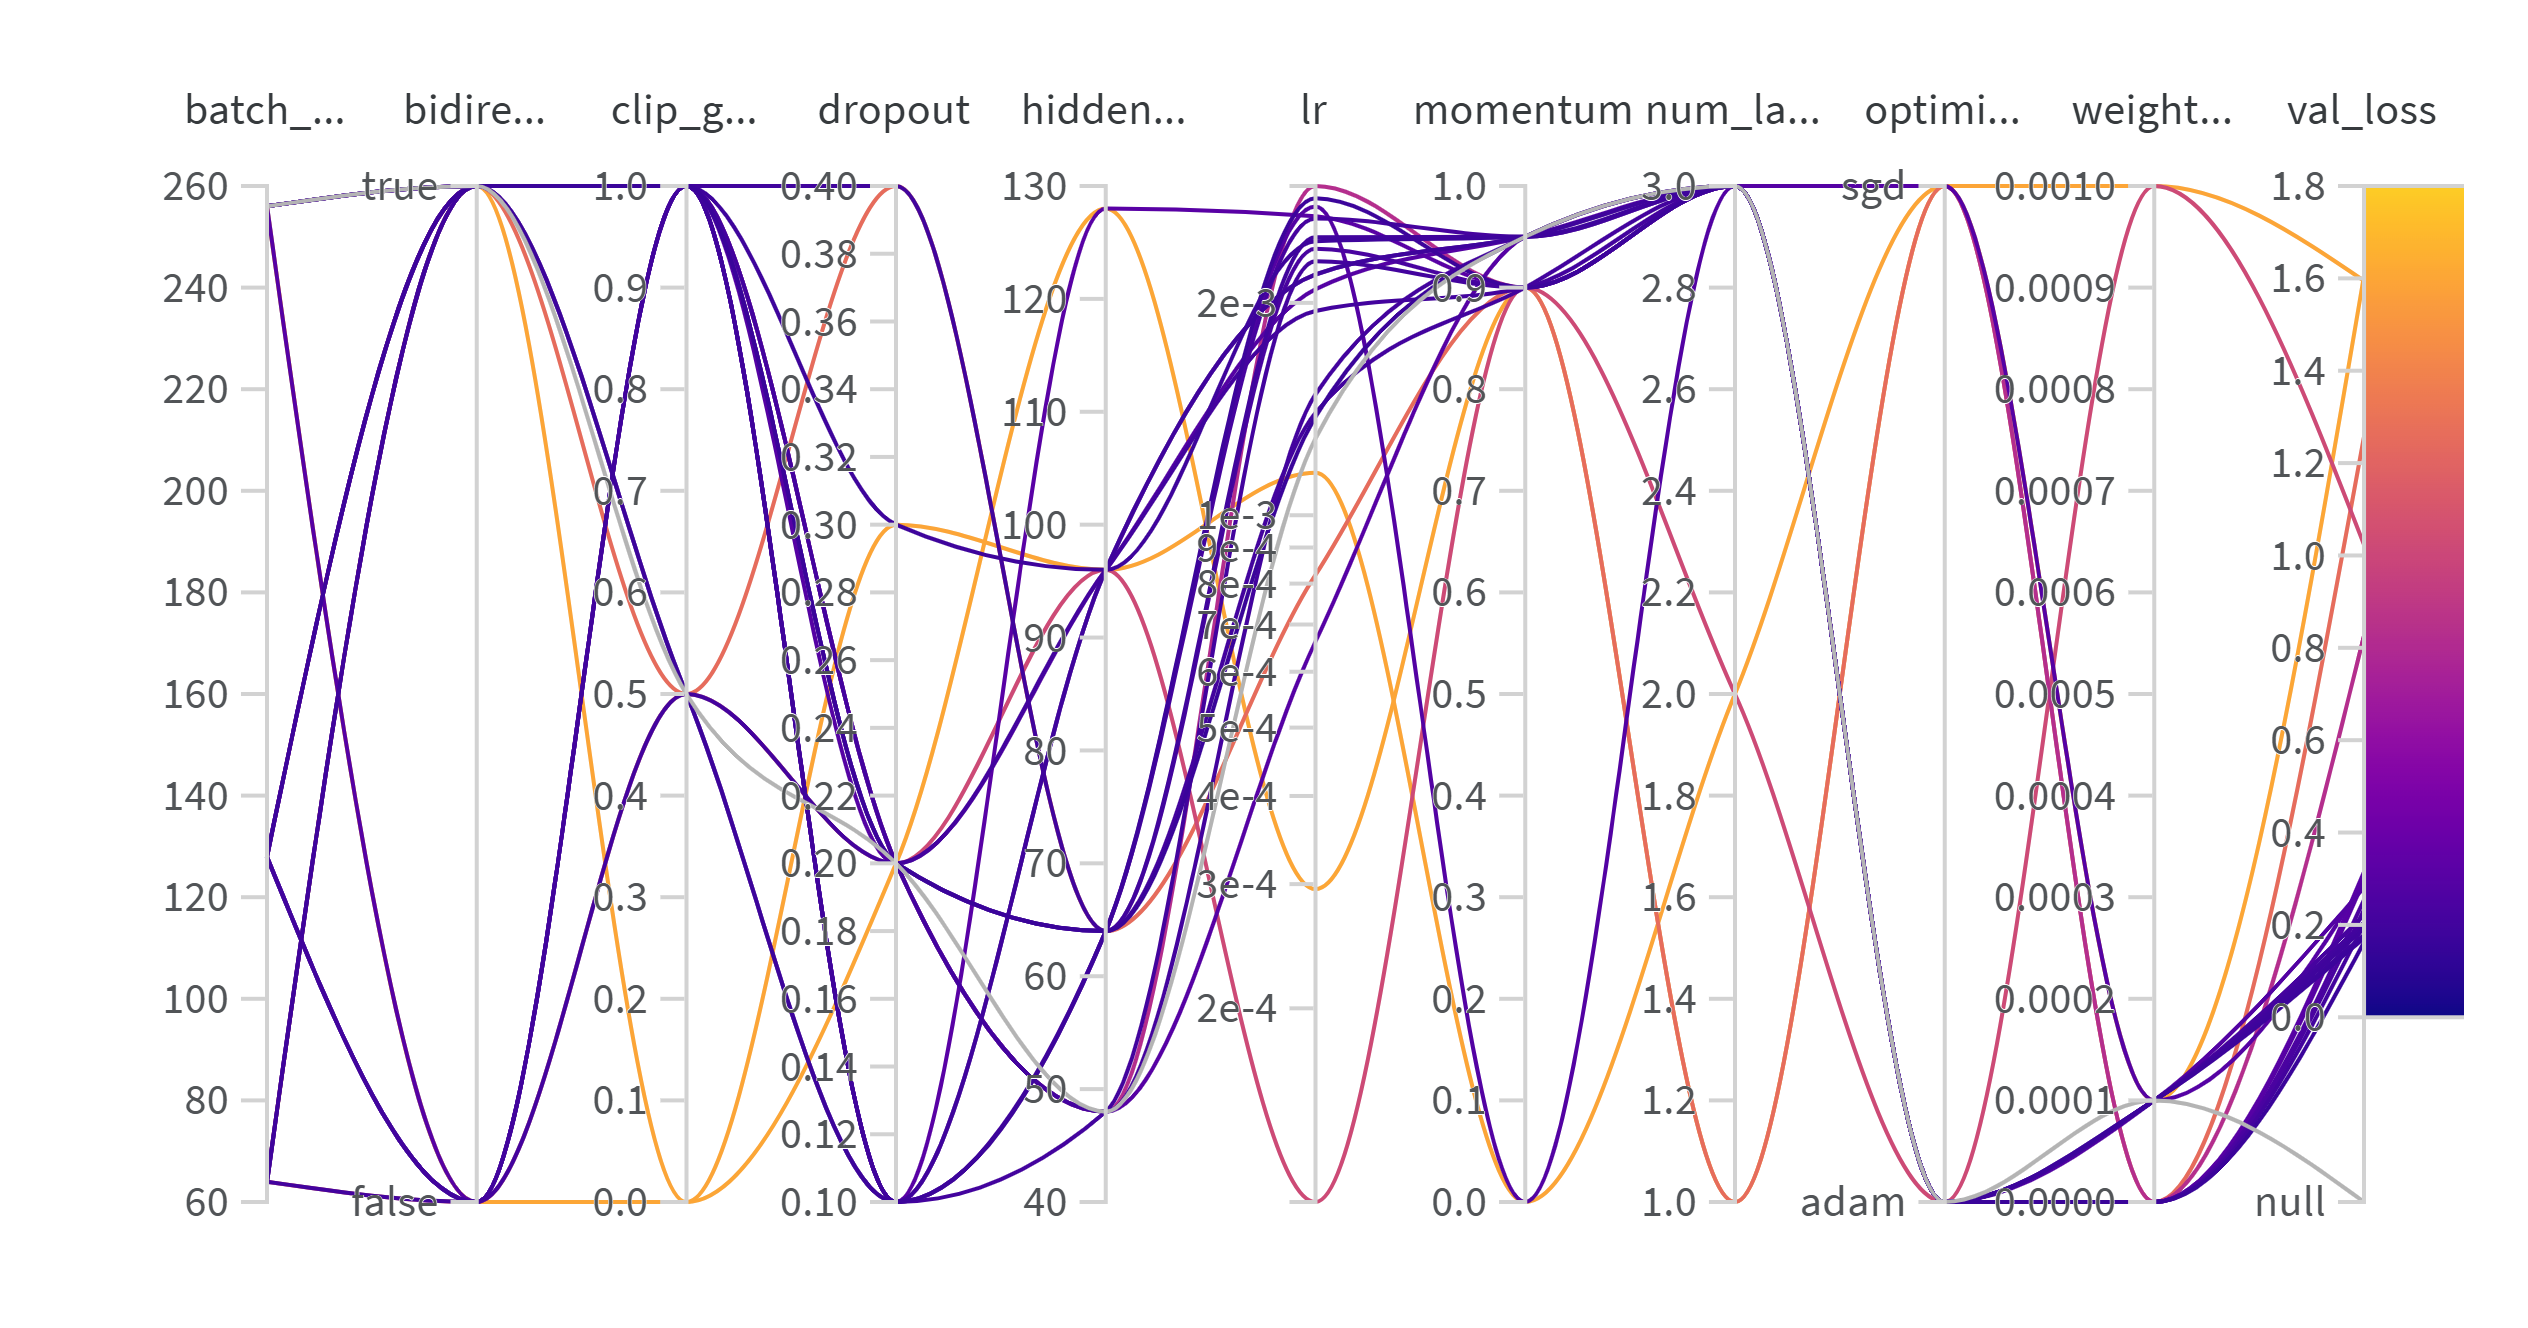

In [43]:
Image("img_wandb.png")

Podemos observar en la imágen cómo afectaron las distintas configuraciones de hiperparámetros a la pérdida en validación. 

* Los casos en los que se utilizo Adam con LR más alto fueron los que obtuvieron mejores resultados.
* Los modelos con num_layers = 3 performaron mejor que los que tenían este hiperparámetro configurado en 1 o 2.
* Los modelos con clip_grad_norm = 1 alcanzaron mejores métricas que el resto.

### Esto también se puede ver en la siguiente imágen que muestra la correlación entre los parámetros y la perdida en validación:

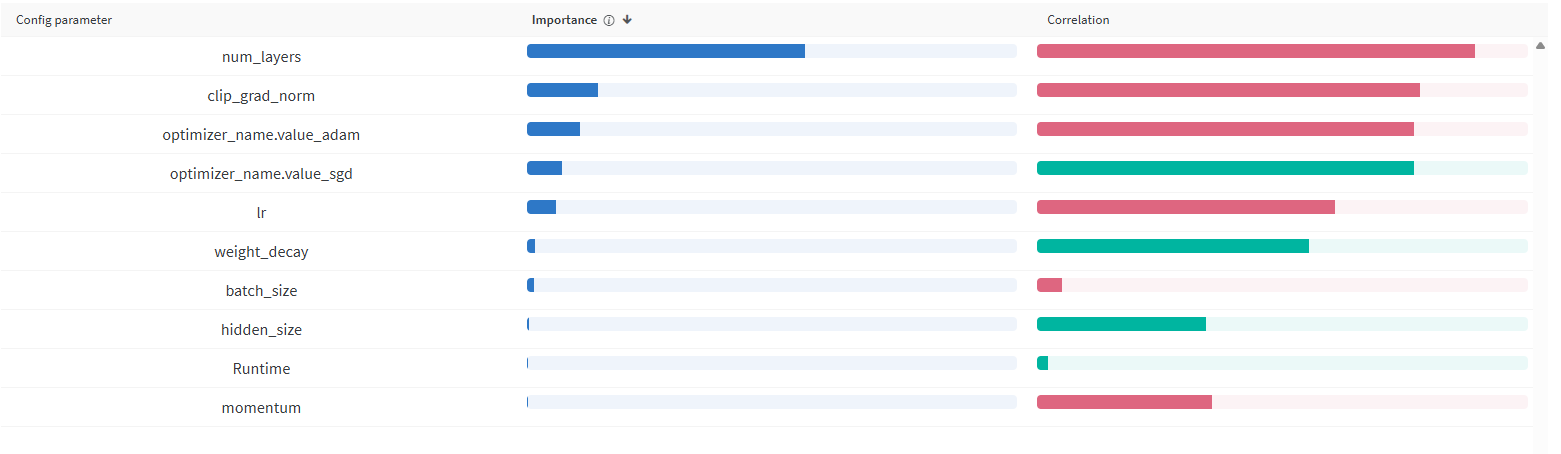

In [44]:
Image("img_wandb_2.png")

## Instanciamos el modelo que obtuvo mejores resultados en Wandb y lo entrenamos

wandb: Agent Starting Run: kkna2gle with config:
wandb: 	batch_size: 256
wandb: 	bidirectional: True
wandb: 	clip_grad_norm: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 64
wandb: 	lr: 0.001379180401976304
wandb: 	momentum: 0.95
wandb: 	num_layers: 3
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0

In [39]:
# Creamos el Modelo
model_wandb = ECG_GRU_WANDB(
    input_size=1,
    hidden_size=64,
    num_layers=3,
    num_classes=5,
    dropout=0.2,
    bidirectional=True
).to(DEVICE)

optimizer = optim.Adam(model_wandb.parameters(),lr=0.001379180401976304,weight_decay=0)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


train_errors, val_errors = utils.train(model_wandb,
    optimizer=optimizer,
    criterion=criterion,
    do_early_stopping=True,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=200,
    patience=15)

Epoch: 001 | Train Loss: 1.58486 | Val Loss: 1.52860
Epoch: 002 | Train Loss: 1.30094 | Val Loss: 1.12015
Epoch: 003 | Train Loss: 1.12141 | Val Loss: 1.03915
Epoch: 004 | Train Loss: 1.02127 | Val Loss: 0.97801
Epoch: 005 | Train Loss: 0.87732 | Val Loss: 0.73323
Epoch: 006 | Train Loss: 0.74492 | Val Loss: 0.64887
Epoch: 007 | Train Loss: 0.65519 | Val Loss: 0.56968
Epoch: 008 | Train Loss: 0.55539 | Val Loss: 0.50899
Epoch: 009 | Train Loss: 0.52206 | Val Loss: 0.50177
Epoch: 010 | Train Loss: 0.48431 | Val Loss: 0.50344
Epoch: 011 | Train Loss: 0.45047 | Val Loss: 0.41037
Epoch: 012 | Train Loss: 0.41170 | Val Loss: 0.39272
Epoch: 013 | Train Loss: 0.38970 | Val Loss: 0.36964
Epoch: 014 | Train Loss: 0.39208 | Val Loss: 0.36311
Epoch: 015 | Train Loss: 0.35397 | Val Loss: 0.34071
Epoch: 016 | Train Loss: 0.34118 | Val Loss: 0.38748
Epoch: 017 | Train Loss: 0.31575 | Val Loss: 0.31385
Epoch: 018 | Train Loss: 0.31105 | Val Loss: 0.31033
Epoch: 019 | Train Loss: 0.28558 | Val Loss: 0

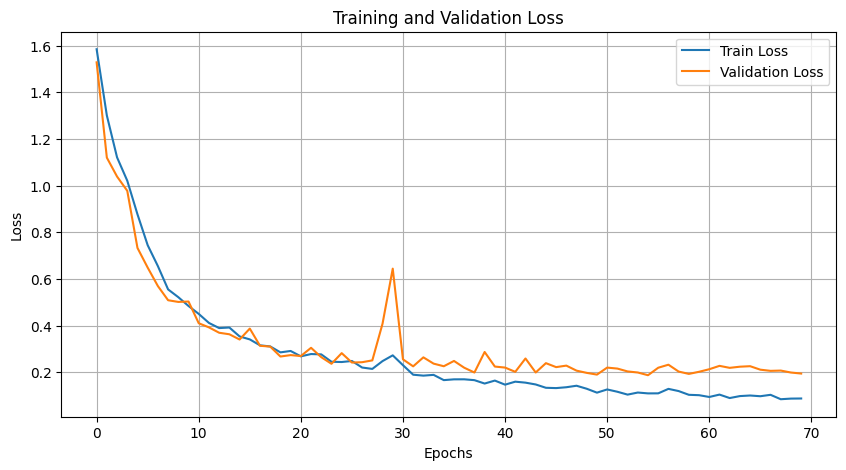

Accuracy: 0.9515

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     18118
           1       0.54      0.85      0.66       556
           2       0.91      0.95      0.93      1448
           3       0.29      0.92      0.45       162
           4       0.97      0.99      0.98      1608

    accuracy                           0.95     21892
   macro avg       0.74      0.93      0.80     21892
weighted avg       0.97      0.95      0.96     21892



In [40]:
utils.plot_taining(train_errors, val_errors)
utils.model_calassification_report(model_wandb, test_loader, DEVICE, nclasses)

Las métricas obtenidas mejoran considerablemente respecto a las que teníamos anteriormente.
Como era de esperar, el modelo destaca en la clasificación de ECG's normales y en la detección de arritmias ventriculares y latidos desconocidos ya que son las 3 clases con una mayor cantidad de muestras en el set.

En cuanto a las clases 1 y 3 (Arritmia Supraventricular y Latido Fusionado) que son los 2 patrones más raros dentro del set de datos, se alcanzó un recall de 0.85 y 0.92 respectivamente, lo que significa que el modelo esta identificando correctamente gran parte de estas anomalías. La precisión baja nos indica que el modelo no esta logrando separar del todo correctamente estas 2 clases.
Es decir, el modelo está detectando arritmias raras casi siempre (recall > 0.85 y > 0.90 en clase 1 y 3) pero fallando en distinguir tipos de arritmias raras entre si. 
